In [1]:
import torch
from torch import Tensor
from torch.nn import Linear
from torch.nn import ReLU
from torch.nn import Tanh
from torch.nn import Sigmoid
from torch.nn import Module
from torch.nn import Embedding 
from torch.optim import SGD,Adam
from torch.nn import Dropout
from torch.nn import CrossEntropyLoss, BCELoss, MSELoss
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, mean_squared_error
import numpy as np
from numpy import vstack
from sklearn.decomposition import PCA
from torch.utils.data import random_split
from torch.nn.init import kaiming_uniform_
from torch.nn.init import xavier_uniform_
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
# model definition
class RNN(Module):
    # define model elements
    # n_inputs: input dimension
    # n_hidden: number of neurons per layer
    # n_layers: number of hidden layers
    def __init__(self, n_hidden, n_layers, input_dim, p_dropout):
        super(RNN, self).__init__()
        
        # hidden layers
        #self.embed = Embedding(input_dim, embedding_dim) 
        self.hidden = {}
        self.act = {}
        for i in range(n_layers):
            if i==0:
                n_in = input_dim + n_hidden # embedding_dim + n_hidden
            else:
                n_in = n_hidden * 2
            # input to hidden layer
            self.hidden[i] = Linear(n_in, n_hidden)
            
            kaiming_uniform_(self.hidden[i].weight, nonlinearity='relu')
            # non-linearity
            self.act[i] = Tanh() # or ReLu
            
        self.dropout = Dropout(p_dropout)
        
        # output
        self.out = Linear(n_hidden,input_dim) # dimension of output is 2
        xavier_uniform_(self.out.weight)
        #self.actout = Sigmoid()
        
        
    # forward propagate input
    def forward(self, X, hidden_layer):
        n_layers = len(hidden_layer)
        
        for i in range(n_layers):
            if i == 0:
                # combine input with previous hidden
                combined = torch.cat((X, hidden_layer[i]), 1)
            else:
                # combine previous hidden with hidden
                combined = torch.cat((hidden_layer[i-1], hidden_layer[i]), 1)
            # input to hidden layer
            hidden_layer[i] = self.hidden[i](combined)
            hidden_layer[i] = self.act[i](hidden_layer[i])
            hidden_layer[i] = self.dropout(hidden_layer[i])
            
        ## output
        output = self.out(hidden_layer[i])
        #output = self.actout(output)

        return output,hidden_layer

In [54]:
# train the model
def train_model(train_x,train_y, val_x,val_y,model):
    n_layers = len(model.hidden)
    n_hidden = model.hidden[0].weight.size()[0]
    # define the optimization
    criterion = MSELoss()
    optimizer = Adam(model.parameters(), lr=0.05)
    
    # enumerate epochs
    all_loss = []
    lossdiff = -1
    epoch = 0
    model.train()
    while lossdiff<0:
        # enumerate batches (xx and xY batch)    
        for xi,yi,xv,yv in zip(train_x,train_y,val_x,val_y):
            
            # initialise hidden states
            batch_size = xi.size()[0]
            batch_size_val = xv.size()[0]
            hi = {}
            hiv = {}
            for k in range(n_layers):
                hi[k] = torch.zeros((batch_size,n_hidden))
                hiv[k] = torch.zeros((batch_size_val,n_hidden))
            l = []
            lv = []
            for j in range(xi.size()[1]):# items in sequence
                xij = xi[:,j,:]
                yij = yi[:,j,:]
                # compute the model output
                yhat,hi = model(xij,hi)
                
                # validation
                xvj = xv[:,j,:]
                yvj = yv[:,j,:]
                yval,hiv = model(xvj,hiv)
                    
                #for k in range(n_layers):
                 #   hi[k] = hi[k].detach()
                    
                if j>xi.size()[1]-6:
                    l.append(criterion(yhat, yij))
                    lv.append(criterion(yval,yvj))
                    
                    
            # clear the gradients
            optimizer.zero_grad()
            # calculate loss on last prediction
            loss = sum(l)#criterion(yhat, yi)
            #loss = criterion(yhat, yij)
            loss.backward(retain_graph=True)
            # update model weights
            optimizer.step()
            
            loss_val = sum(lv)#criterion(yval, yvj)#sum(lv)
        
        all_loss.append(loss_val.item())  
        if epoch>5:
            lossdiff = all_loss[-1]-np.mean(all_loss[-5:-1] )
        epoch +=1
    return all_loss


def predict(x,model):
    
    n_layers = len(model.hidden)
    n_hidden = model.hidden[0].weight.size()[0]

    
    y = []
    h = []
    c = []
    model.eval()
    for xi in x:
        batch_size = xi.size()[0]
        hi = {}
        for k in range(n_layers):
            hi[k] = torch.zeros((batch_size,n_hidden))
        
        for j in range(xi.size()[1]):
            xij = xi[:,j,:]
            # compute the model output
            yhat,hi = model(xij,hi)
            
        yhat = yhat.detach().numpy() # predicted stimulus
        #ci = np.round(yhat) != xij.detach().numpy()
        ##print(np.sum(ci,1))
        #ci =  ((np.sum(ci,1)==0)==False).astype(int) # predicted sameness 1=change, 0=same
        y.append(yhat)
        #c.append(ci)
        h.append(hi)
        
    return y,h #,c


Create input sequences

In [59]:
def unique_pairs(dictionary):
    '''
    create matrix with unique pairs of (one-hot) vectors in dictionary
    
    dictionary: N x dimensionality; matrix of N (one-hot) vectors
    '''
    vecpairs = []
    for i in range(dictionary.shape[0]):
        for j in range(dictionary.shape[0]):
            if i!=j:
                vecpairs.append(np.vstack((dictionary[j,],dictionary[i,])))
    vecpairs = np.array(vecpairs) 
    return vecpairs

def make_sequence(seq,repeats,pairs,zero_vector,deviance_prob):
    
    '''
    Create a structured sequence such as 010101, replacing 0 and 1 with (one-hot) vectors from dictionary
    
    batch_size: number of sequence samples with different value for 0 and 1
    seq: list of sequence structures
    repeats: repeats per sequence chunk (e.g. 4 = 4xsize of sequence chunk)
    dictionary: matrix of (one-hot) vectors, shape: dic size X input size
    zero_vector: vector to be used for the zero state
    deviance_prob: probability of global deviant
    '''
    nseq = len(seq)
    x = np.zeros((nseq))
    input_size = pairs.shape[2]
    batch_size = pairs.shape[0]
    all_seq = []
    seq_len = []
    for s in seq:
        
        # pick value from dictionary:
        a = []
        b = []
        c = []
        for i in range(batch_size):
            a.append(pairs[i,0,:]) # X
            b.append(pairs[i,1,:]) # Y
            if pairs.shape[1]==3:
                c.append(pairs[i,2,:]) # Z
        a = np.array(a)
        b = np.array(b)
        c = np.array(c)
        # create sequence
        sequence = []
        for i,element in enumerate(s):
            if element==0:
                sequence.append(a)
            elif element==1:
                sequence.append(b)
            elif element==2:
                sequence.append(c)
        sequence = np.array(sequence)
         
        sequence = np.swapaxes(sequence,0,1)
        # add zero state
        sequence = np.concatenate((sequence,np.repeat(zero_vector[None,:,:],batch_size,0)),1)
        out_sequence = sequence
        global_deviants = np.round(np.random.rand(repeats-2)-(0.5-deviance_prob))
        for r in range(repeats-1):
            # stack the sequence repeat times
            out_sequence = np.concatenate((out_sequence,sequence),1)
            # insert global deviant according to global_Deviants for all chunks but last
            if r<repeats-2:
                if global_deviants[r]==1:
                    # check wich item is the last
                    if np.mean(out_sequence[:,-2]==a):
                        out_sequence[:,-2]=b #switch
                    else:
                        out_sequence[:,-2]=a
                
        all_seq.append(out_sequence)

    return all_seq


### Training & Testing on structure switch

In [372]:
seq = [[0,0,0,0],[0,0,0,1],[0,1,0,1],[0,0,1,1],[1,1,1,1],[1,1,1,0]] # sequence structures to be used
seq_test = [[0,0,0,0],[0,0,0,1],[1,1,1,1],[1,1,1,0]]
seq_test2 = [[0,0,0,1],[0,0,0,0],[1,1,1,0],[1,1,1,1]] # those are the global deviants
Nseq = len(seq_test)
repeats = 10 # repeats per chunk in each sequence
input_size = 64 # dimensionality of the input
dict_size = 100 # size of stimulus dictionary
n_hidden = 1024
n_layers = 1
deviance_prob = 0.2
p_dropout = 0

# produce random stimulus pairs:
dictionary = np.random.randn(dict_size,input_size)
pairs = np.random.randn(dict_size,3,input_size) 
pairs_val = np.random.randn(dict_size,3,input_size)
pairs_test = np.random.randn(dict_size,3,input_size)
pairs_test_samestim = pairs.copy()[np.random.permutation(pairs.shape[0]),:,:] # shuffle pairs from trained stimuli
zero_vector = np.random.randn(1,input_size) # this is used for the zero state
all_stimuli = np.concatenate((np.reshape(pairs_test,(dict_size*3,input_size)),zero_vector),0)
all_stimuli_samestim = np.concatenate((np.reshape(pairs_test_samestim,(pairs.shape[0]*3,input_size)),zero_vector),0)
nstim = all_stimuli.shape[0]
    
# create training and test data
sequence = make_sequence(seq,repeats,pairs,zero_vector,deviance_prob)
test_sequence = make_sequence(seq_test,repeats,pairs_test,zero_vector,0)
test_sequence2 = make_sequence(seq_test2,2,pairs_test,zero_vector,0)
val_sequence = make_sequence(seq,repeats,pairs_val,zero_vector,0)
test_sequence_samestim = make_sequence(seq_test,repeats,pairs_test_samestim,zero_vector,0)
test_sequence2_samestim = make_sequence(seq_test2,2,pairs_test_samestim,zero_vector,0)
# concatenate both test sequences
for i in range(len(seq_test)):
    test_sequence[i] = np.concatenate((test_sequence[i],test_sequence2[i]),1)
    test_sequence_samestim[i] = np.concatenate((test_sequence_samestim[i],test_sequence2_samestim[i]),1)


print('%s units per layer, %s layer'%(n_hidden,n_layers))

# make torch variables
train_x = []
train_y = []
val_x = []
val_y = []
for i in range(len(seq)):
    #trainind = np.delete(np.arange(ntrials),k)
    train_x.append(torch.Tensor(sequence[i][:,:-2,:])) #!!-1 if no zero element after each chunk, otherwise -2
    train_y.append(torch.Tensor(sequence[i][:,1:-1,:])) 
    val_x.append(torch.Tensor(val_sequence[i][:,:-2,:]))
    val_y.append(torch.Tensor(val_sequence[i][:,1:-1,:]))
    
# train network
model = RNN(n_hidden,n_layers,input_size,p_dropout)
Loss = train_model(train_x,train_y, val_x,val_y,model)


# evaluation
Acc, Acc10, Acc_samestim, Acc10_samestim, AngleAll, AngleAll_samestim, Angle, Yhat, Yhat_samestim, Ytrue, Ytrue_samestim, Hidden, Hidden_samestim = [],[],[],[],[],[],[],[],[],[],[],[],[] 
print('Evaluate...')
for i in range(Nseq):
    Nback = 3*len(seq_test[i]) + 3 # predict last N=LENGTH*3 items of sequence; + 3 for zero states
    
    # pre-allocate
    Acc.append(np.zeros((Nback,dict_size)))
    Acc10.append(np.zeros((Nback,dict_size)))
    Acc_samestim.append(np.zeros((Nback,pairs.shape[0])))
    Acc10_samestim.append(np.zeros((Nback,pairs.shape[0])))
    AngleAll.append(np.zeros((Nback,dict_size,nstim)))
    AngleAll_samestim.append(np.zeros((Nback,pairs.shape[0],nstim)))
    Angle.append(np.zeros((Nback,dict_size)))
    Yhat.append(np.zeros((dict_size,Nback,input_size))) # store prediction here
    Ytrue.append(np.zeros((dict_size,Nback,input_size))) # store ground truth
    Yhat_samestim.append(np.zeros((pairs.shape[0],Nback,input_size)) )# store prediction here
    Ytrue_samestim.append(np.zeros((pairs.shape[0],Nback,input_size)) )# store ground truth
    Hidden.append(np.zeros((dict_size,Nback,n_hidden)) )# hidden state activity
    Hidden_samestim.append(np.zeros((pairs.shape[0],Nback,n_hidden)))

    
    test_x = []
    for j in range(Nback):
        if j==Nback-1:
            test_x.append(torch.Tensor(test_sequence[i]))
        else:
            test_x.append(torch.Tensor(test_sequence[i][:,:-Nback+j+1 ,:]))

    y,h = predict(test_x,model)

    for j in range(Nback):
        Yhat[i][:,j,:] = y[j]
        if j==Nback-1:
            Ytrue[i][:,j,:] = test_sequence[i][:,-Nback,:]
        else:
            Ytrue[i][:,j,:] = test_sequence[i][:,-Nback+j+1 ,:] # last item is zero state
        Hidden[i][:,j,:] = h[j][0].detach().numpy()
    
    
    # for the stimuli trained on
    test_x = []
    for j in range(Nback):
        if j==Nback-1:
            test_x.append(torch.Tensor(test_sequence_samestim[i]))
        else:
            test_x.append(torch.Tensor(test_sequence_samestim[i][:,:-Nback+j+1 ,:]))

    y,h = predict(test_x,model)

    for j in range(Nback):
        Yhat_samestim[i][:,j,:] = y[j]
        if j==Nback-1:
            Ytrue_samestim[i][:,j,:] = test_sequence_samestim[i][:,-Nback,:]
        else:
            Ytrue_samestim[i][:,j,:] = test_sequence_samestim[i][:,-Nback+j+1 ,:] # last item is zero state
        Hidden_samestim[i][:,j,:] = h[j][0].detach().numpy()
        
    # compute angles and accuracy
    print('Compute accuracy sequence %s'%seq_test[i])
    for j in range(Nback): # items in sequence
        for k in range(dict_size):
            
            # test sequences
            yhat = Yhat[i][k,j,:]
            ytrue = Ytrue[i][k,j,:]
            yrep = np.repeat(ytrue[None,:],nstim,0)
            target_idx = np.argmin(np.mean(abs(yrep-all_stimuli),1))
            
            # angle with all vectors in dictionary
            ynorm = yhat/np.linalg.norm(yhat)
            dic = np.array([all_stimuli[u,:]/np.linalg.norm(all_stimuli[u,:]) for u in range(nstim)])
            for s in range(nstim):
                AngleAll[i][j,k,s] = np.arccos(ynorm@dic[s,:]) * 180/np.pi
            # angle with correct vector
            Angle[i][j,k] = AngleAll[i][j,k,target_idx]
            Acc[i][j,k] = np.argmin(AngleAll[i][j,k,:])==target_idx
            Acc10[i][j,k] = target_idx in np.argsort(AngleAll[i][j,k,:])[:10]
        
        for k in range(pairs.shape[0]):    
            # stimuli trained on
            yhat = Yhat_samestim[i][k,j,:]
            ytrue = Ytrue_samestim[i][k,j,:]
            yrep = np.repeat(ytrue[None,:],all_stimuli_samestim.shape[0],0)
            target_idx = np.argmin(np.mean(abs(yrep-all_stimuli_samestim),1))
            
            ynorm = yhat/np.linalg.norm(yhat)
            dic = np.array([all_stimuli_samestim[u,:]/np.linalg.norm(all_stimuli_samestim[u,:]) for u in range(all_stimuli_samestim.shape[0])])
            for s in range(nstim):
                AngleAll_samestim[i][j,k,s] = np.arccos(ynorm@dic[s,:]) * 180/np.pi
            # angle with correct vector
            Acc_samestim[i][j,k] = np.argmin(AngleAll_samestim[i][j,k,:])==target_idx
            Acc10_samestim[i][j,k] = target_idx in np.argsort(AngleAll_samestim[i][j,k,:])[:10]
            
for i in range(Nseq):
    mean_acc = np.mean(Acc[i][len(seq_test[i])-2,:])
    mean_acc10 = np.mean(Acc10[i][len(seq_test[i])-2,:])
    print('New stimuli; Accuracy for last in sequence %s: %.3f, 10shot: %.3f'%(seq_test[i],mean_acc,mean_acc10))
    
mean_acc = []
for i in range(Nseq):
    mean_acc = np.mean(Acc_samestim[i][len(seq_test[i])-2,:])
    mean_acc10 = np.mean(Acc10_samestim[i][len(seq_test[i])-2,:])
    print('Known stimuli; Accuracy for last in sequence %s: %.3f, 10shot: %.3f'%(seq_test[i],mean_acc,mean_acc10))

1024 units per layer, 1 layer
Evaluate...
Compute accuracy sequence [0, 0, 0, 0]
Compute accuracy sequence [0, 0, 0, 1]
Compute accuracy sequence [1, 1, 1, 1]
Compute accuracy sequence [1, 1, 1, 0]
New stimuli; Accuracy for last in sequence [0, 0, 0, 0]: 1.000, 10shot: 1.000
New stimuli; Accuracy for last in sequence [0, 0, 0, 1]: 0.720, 10shot: 1.000
New stimuli; Accuracy for last in sequence [1, 1, 1, 1]: 1.000, 10shot: 1.000
New stimuli; Accuracy for last in sequence [1, 1, 1, 0]: 0.790, 10shot: 1.000
Known stimuli; Accuracy for last in sequence [0, 0, 0, 0]: 1.000, 10shot: 1.000
Known stimuli; Accuracy for last in sequence [0, 0, 0, 1]: 1.000, 10shot: 1.000
Known stimuli; Accuracy for last in sequence [1, 1, 1, 1]: 1.000, 10shot: 1.000
Known stimuli; Accuracy for last in sequence [1, 1, 1, 0]: 1.000, 10shot: 1.000


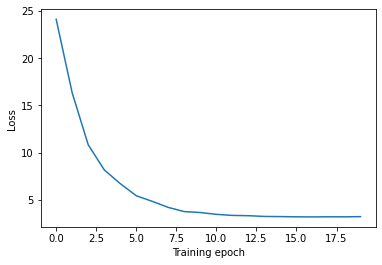

In [367]:
plt.plot(Loss)

plt.ylabel('Loss')
plt.xlabel('Training epoch')
plt.savefig('NIP_validationLoss.png')
plt.show()

### Visualize results

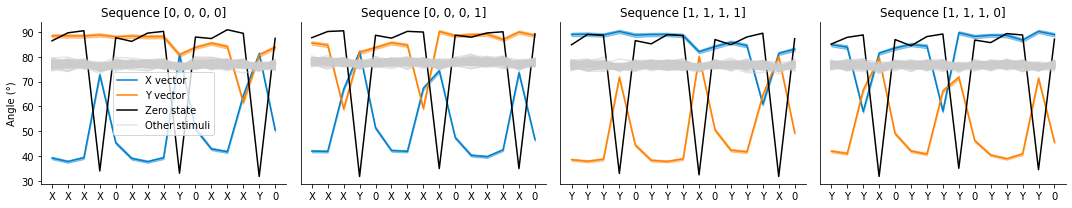

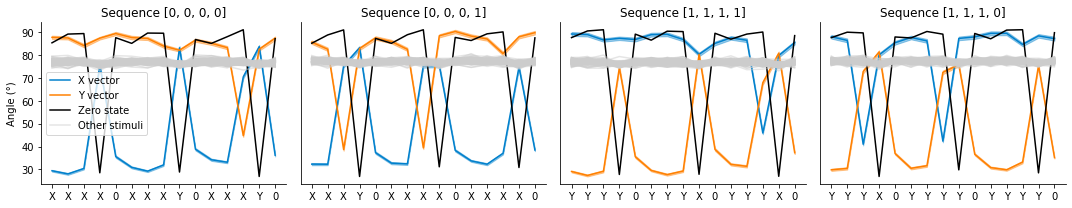

In [373]:
# PLOT ANGLE FOR EACH STIMULUS X WITH ITS CORRESPONDING VECTOR AND THE OTHER VECTOR Y
xlabels = ['X','Y','Z','0'] # for correct x ticks


test_seq = []
for i in range(len(seq_test)):
    test_seq.append(np.concatenate((seq_test[i],[3],seq_test2[i],[3],seq_test2[i],[3]))) 
    # this is the sequence evaluated in the previous cell

    
# FOR NEW STIMULI
TargetResp = []
SmallestResp = []
for which_seq in range(Nseq): # loop through sequences
    Nback = len(seq_test[which_seq])*3 + 3
    TargetResp.append(np.zeros((Nback,pairs_test.shape[0],3)))
    SmallestResp.append(np.zeros((Nback,pairs_test.shape[0])))
    for stimulus in range(pairs_test.shape[0]): # loop through all stimuli
        for i in range(3):                
            TargetResp[which_seq][:,stimulus,i] = AngleAll[which_seq][:,stimulus,stimulus*3+i]
        # get vector closest to the selected but first three
        SmallestResp[which_seq][:,stimulus] = np.sort(np.delete(AngleAll[which_seq][:,stimulus,:],(stimulus*3,stimulus*3+2,stimulus*3+1),-1),-1)[:,int(dict_size*0.1)]
fig,ax = plt.subplots(1,Nseq,figsize=(15,3))
col = [[0,.5,.8],[1,.5,0],[0.3,.7,0]]
for which_seq in range(Nseq):
    N = len(seq_test[which_seq])*3 + 3
    for i in range(2):
        m = np.mean(TargetResp[which_seq][:,:,i],1)
        sem = np.std(TargetResp[which_seq][:,:,i],1)/np.sqrt(pairs.shape[0])
        ax[which_seq].plot(np.arange(N),m,color=col[i])
        ax[which_seq].fill_between(np.arange(N),m-sem,m+sem,color=col[i],alpha=.4)
    m = np.mean(AngleAll[which_seq][:,:,-1],1)
    ax[which_seq].plot(np.arange(N),m,color=[0,0,0])
    #m = np.min(AngleAll[which_seq][:,:,:,],1)
    ax[which_seq].plot(np.arange(N),SmallestResp[which_seq],color=[.8,.8,.8],alpha=.5)
    ax[which_seq].spines['right'].set_visible(False)
    ax[which_seq].spines['top'].set_visible(False)
    ax[which_seq].set_title('Sequence %s'%seq_test[which_seq])
    ax[which_seq].set_xticks(np.arange(N))
    ticks = []
    for t in range(N):
        ticks.append(xlabels[test_seq[which_seq][t]])
    ax[which_seq].set_xticklabels(ticks)
    if which_seq>0:
        ax[which_seq].set_yticks(())
    ax[0].set_ylabel('Angle (°)')
    ax[0].legend(['X vector','Y vector','Zero state','Other stimuli'])
plt.tight_layout()
#plt.savefig('NIP_Angles_local-global_generalization.pdf')
#plt.savefig('NIP_Angles_local-global_generalization.png')
plt.show()


# FOR KNOWN STIMULI
TargetResp = []
for which_seq in range(Nseq): # loop through sequences
    Nback = len(seq_test[which_seq])*3 + 3
    TargetResp.append(np.zeros((Nback,pairs.shape[0],3)))
    SmallestResp.append(np.zeros((Nback,pairs.shape[0])))
    for stimulus in range(pairs.shape[0]): # loop through all stimuli
        for i in range(2):                
            TargetResp[which_seq][:,stimulus,i] = AngleAll_samestim[which_seq][:,stimulus,stimulus*3+i]
        SmallestResp[which_seq][:,stimulus] = np.sort(np.delete(AngleAll[which_seq][:,stimulus,:],(stimulus*3,stimulus*3+2,stimulus*3+1),-1),-1)[:,int(pairs.shape[0]*0.1)]
        
fig,ax = plt.subplots(1,Nseq,figsize=(15,3))
col = [[0,.5,.8],[1,.5,0],[0.3,.7,0]]
for which_seq in range(Nseq):
    N = len(seq_test[which_seq])*3 + 3
    for i in range(2):
        m = np.mean(TargetResp[which_seq][:,:,i],1)
        sem = np.std(TargetResp[which_seq][:,:,i],1)/np.sqrt(pairs.shape[0])
        ax[which_seq].plot(np.arange(N),m,color=col[i])
        ax[which_seq].fill_between(np.arange(N),m-sem,m+sem,color=col[i],alpha=.4)
    m = np.mean(AngleAll_samestim[which_seq][:,:,-1],1)
    ax[which_seq].plot(np.arange(N),m,color=[0,0,0])
    #m = np.mean(AngleAll_samestim[which_seq][:,:,:,],1)
    ax[which_seq].plot(np.arange(N),SmallestResp[which_seq],color=[.8,.8,.8],alpha=.5)
    ax[which_seq].spines['right'].set_visible(False)
    ax[which_seq].spines['top'].set_visible(False)
    ax[which_seq].set_title('Sequence %s'%seq_test[which_seq])
    ax[which_seq].set_xticks(np.arange(N))
    ticks = []
    for t in range(N):
        ticks.append(xlabels[test_seq[which_seq][t]])
    ax[which_seq].set_xticklabels(ticks)
    if which_seq>0:
        ax[which_seq].set_yticks(())
    ax[0].set_ylabel('Angle (°)')
    ax[0].legend(['X vector','Y vector','Zero state','Other stimuli'])
plt.savefig('NIP_Angles.pdf')
plt.tight_layout()
#plt.savefig('NIP_Angles_local-global.pdf')
#plt.savefig('NIP_Angles_local-global.png')
plt.show()


In [82]:
pairs.shape[0]

90

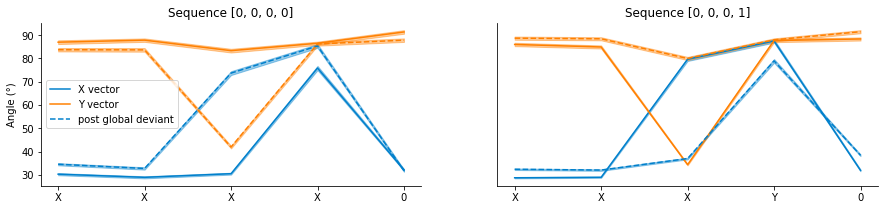

In [119]:
# overlay global standard and post-global deviant
fig,ax = plt.subplots(1,Nseq,figsize=(15,3))
col = [[0,.5,.8],[1,.5,0]]
markers = ['-','--']
for which_seq in range(Nseq):
    N = len(seq_test[which_seq]) + 1
    for n,step in enumerate([0,2]):
        for i in range(2):
        
            m = np.mean(TargetResp[which_seq][5*step:5*(step+1),:,i],1)
            sem = np.std(TargetResp[which_seq][5*step:5*(step+1),:,i],1)/np.sqrt(pairs.shape[0])
            ax[which_seq].plot(np.arange(5),m,color=col[i],linestyle=markers[n])
            ax[which_seq].fill_between(np.arange(5),m-sem,m+sem,color=col[i],alpha=.4)
        #m = np.mean(np.mean(TargetResp[which_seq,:,:,:,5*n:5*(n+1)],2),1).T
        #ax[which_seq].plot(np.arange(5),m,color=[.8,.8,.8],alpha=.5)
    ax[which_seq].set_xticks(np.arange(5))
    ax[which_seq].spines['right'].set_visible(False)
    ax[which_seq].spines['top'].set_visible(False)
    ax[which_seq].set_title('Sequence %s'%seq_test[which_seq])
    ticks = []
    for t in range(5):
        ticks.append(xlabels[test_seq[which_seq][t]])
    ax[which_seq].set_xticklabels(ticks)
    if which_seq>0:
        ax[which_seq].set_yticks(())
    ax[0].set_ylabel('Angle (°)')
    ax[0].legend(['X vector','Y vector','post global deviant'])
plt.savefig('NIP_Angles_Overlay.pdf')
plt.savefig('NIP_Angles_Overlay.png')
plt.show()

# Grid search

In [110]:
seq = [[0,0,0,0],[0,0,0,1],[0,1,0,1],[0,0,1,1],] # sequence structures to be used
seq_test = [[0,0,0,0],[0,0,0,1]]
Nseq = len(seq_test)
repeats = 10 # repeats per chunk in each sequence
in_size = [1,2,4,8,16,32,64,128] # dimensionality of the input
dict_size = 100 # size of stimulus dictionary
hidden = [1,2,4,8,16,32,64,128,256,512,1024]
n_layers = 1
deviance_prob = 0.2
p_dropout = 0

Accuracy, Accuracy10 = np.zeros((len(in_size),len(hidden),Nseq,dict_size)), np.zeros((len(in_size),len(hidden),Nseq,dict_size))
for ii,input_size in enumerate(in_size):
    # produce random stimulus pairs:
    pairs = np.random.randn(dict_size,3,input_size) 
    pairs_val = np.random.randn(dict_size,3,input_size)
    pairs_test = np.random.randn(dict_size,3,input_size)
    pairs_test_samestim = pairs.copy()[np.random.permutation(dict_size),:,:] # shuffle pairs from trained stimuli
    zero_vector = np.random.randn(1,input_size) # this is used for the zero state
    all_stimuli = np.concatenate((np.reshape(pairs_test,(dict_size*3,input_size)),zero_vector),0)
    all_stimuli_samestim = np.concatenate((np.reshape(pairs_test_samestim,(dict_size*3,input_size)),zero_vector),0)
    nstim = all_stimuli.shape[0]
    
    # create training and test data
    sequence = make_sequence(seq,repeats,pairs,zero_vector,deviance_prob)
    test_sequence = make_sequence(seq_test,repeats,pairs_test,zero_vector,0)
    val_sequence = make_sequence(seq,repeats,pairs_val,zero_vector,0)
    test_sequence_samestim = make_sequence(seq_test,repeats,pairs_test_samestim,zero_vector,0)

    # make torch variables
    train_x = []
    train_y = []
    val_x = []
    val_y = []
    for i in range(len(seq)):
        #trainind = np.delete(np.arange(ntrials),k)
        train_x.append(torch.Tensor(sequence[i][:,:-2,:])) #!!-1 if no zero element after each chunk, otherwise -2
        train_y.append(torch.Tensor(sequence[i][:,1:-1,:])) 
        val_x.append(torch.Tensor(val_sequence[i][:,:-2,:]))
        val_y.append(torch.Tensor(val_sequence[i][:,1:-1,:]))
    
    # train network
    for hi,n_hidden in enumerate(hidden):
    
        print('%s units per layer, %s layer, %s input dimensions'%(n_hidden,n_layers,input_size))
        model = RNN(n_hidden,n_layers,input_size, p_dropout)
        Loss = train_model(train_x,train_y, val_x,val_y,model)


        # evaluation
        Acc, Acc10, Acc_samestim, Acc10_samestim, AngleAll, AngleAll_samestim, Angle, Yhat, Yhat_samestim, Ytrue, Ytrue_samestim, Hidden = [],[],[],[],[],[],[],[],[],[],[],[] 
        print('Evaluate...')
        for i in range(Nseq):
            Nback = len(seq_test[i]) + 1 # predict last N=LENGTH*3 items of sequence; + 3 for zero states
            
            # pre-allocate
            Acc.append(np.zeros((Nback,dict_size)))
            Acc10.append(np.zeros((Nback,dict_size)))
            Acc_samestim.append(np.zeros((Nback,dict_size)))
            Acc10_samestim.append(np.zeros((Nback,dict_size)))
            AngleAll.append(np.zeros((Nback,dict_size,nstim)))
            AngleAll_samestim.append(np.zeros((Nback,dict_size,nstim)))
            Angle.append(np.zeros((Nback,dict_size)))
            Yhat.append(np.zeros((dict_size,Nback,input_size))) # store prediction here
            Ytrue.append(np.zeros((dict_size,Nback,input_size))) # store ground truth
            Yhat_samestim.append(np.zeros((dict_size,Nback,input_size)) )# store prediction here
            Ytrue_samestim.append(np.zeros((dict_size,Nback,input_size)) )# store ground truth
            Hidden.append(np.zeros((dict_size,Nback,n_hidden)) )# hidden state activity
        
            
            test_x = []
            for j in range(Nback):
                if j==Nback-1:
                    test_x.append(torch.Tensor(test_sequence[i]))
                else:
                    test_x.append(torch.Tensor(test_sequence[i][:,:-Nback+j+1 ,:]))
        
            y,h = predict(test_x,model)
        
            for j in range(Nback):
                Yhat[i][:,j,:] = y[j]
                if j==Nback-1:
                    Ytrue[i][:,j,:] = test_sequence[i][:,-Nback,:]
                else:
                    Ytrue[i][:,j,:] = test_sequence[i][:,-Nback+j+1 ,:] # last item is zero state
                Hidden[i][:,j,:] = h[j][0].detach().numpy()
            
            
            # for the stimuli trained on
            test_x = []
            for j in range(Nback):
                if j==Nback-1:
                    test_x.append(torch.Tensor(test_sequence_samestim[i]))
                else:
                    test_x.append(torch.Tensor(test_sequence_samestim[i][:,:-Nback+j+1 ,:]))
        
            y,h = predict(test_x,model)
        
            for j in range(Nback):
                Yhat_samestim[i][:,j,:] = y[j]
                if j==Nback-1:
                    Ytrue_samestim[i][:,j,:] = test_sequence_samestim[i][:,-Nback,:]
                else:
                    Ytrue_samestim[i][:,j,:] = test_sequence_samestim[i][:,-Nback+j+1 ,:] # last item is zero state
        
            # compute angles and accuracy
            print('Compute accuracy sequence %s'%seq_test[i])
            for j in range(Nback): # items in sequence
                for k in range(dict_size):
                    
                    # test sequences
                    yhat = Yhat[i][k,j,:]
                    ytrue = Ytrue[i][k,j,:]
                    yrep = np.repeat(ytrue[None,:],nstim,0)
                    target_idx = np.argmin(np.mean(abs(yrep-all_stimuli),1))
                    
                    # angle with all vectors in dictionary
                    ynorm = yhat/np.linalg.norm(yhat)
                    dic = np.array([all_stimuli[u,:]/np.linalg.norm(all_stimuli[u,:]) for u in range(nstim)])
                    for s in range(nstim):
                        AngleAll[i][j,k,s] = np.arccos(ynorm@dic[s,:]) * 180/np.pi
                    # angle with correct vector
                    Angle[i][j,k] = AngleAll[i][j,k,target_idx]
                    Acc[i][j,k] = np.argmin(AngleAll[i][j,k,:])==target_idx
                    Acc10[i][j,k] = target_idx in np.argsort(AngleAll[i][j,k,:])[:10]
                    
                    # stimuli trained on
                    yhat = Yhat_samestim[i][k,j,:]
                    ytrue = Ytrue_samestim[i][k,j,:]
                    yrep = np.repeat(ytrue[None,:],nstim,0)
                    target_idx = np.argmin(np.mean(abs(yrep-all_stimuli_samestim),1))
                    
                    ynorm = yhat/np.linalg.norm(yhat)
                    dic = np.array([all_stimuli_samestim[u,:]/np.linalg.norm(all_stimuli_samestim[u,:]) for u in range(nstim)])
                    for s in range(nstim):
                        AngleAll_samestim[i][j,k,s] = np.arccos(ynorm@dic[s,:]) * 180/np.pi
                    # angle with correct vector
                    Acc_samestim[i][j,k] = np.argmin(AngleAll_samestim[i][j,k,:])==target_idx
                    Acc10_samestim[i][j,k] = target_idx in np.argsort(AngleAll_samestim[i][j,k,:])[:10]
                    
        for i in range(Nseq):
            Accuracy[ii,hi,i,:] = Acc[i][len(seq_test[i])-2,:]
            Accuracy10[ii,hi,i,:] = Acc10[i][len(seq_test[i])-2,:]
            mean_acc = np.mean(Acc[i][len(seq_test[i])-2,:])
            mean_acc10 = np.mean(Acc10[i][len(seq_test[i])-2,:])
            print('New stimuli; Accuracy for last in sequence %s: %.3f, 10shot: %.3f'%(seq_test[i],mean_acc,mean_acc10))
            
        mean_acc = []
        for i in range(Nseq):
            mean_acc = np.mean(Acc_samestim[i][len(seq_test[i])-2,:])
            mean_acc10 = np.mean(Acc10_samestim[i][len(seq_test[i])-2,:])
            print('Known stimuli; Accuracy for last in sequence %s: %.3f, 10shot: %.3f'%(seq_test[i],mean_acc,mean_acc10))

1 units per layer, 1 layer, 1 input dimensions
Evaluate...
Compute accuracy sequence [0, 0, 0, 0]
Compute accuracy sequence [0, 0, 0, 1]
New stimuli; Accuracy for last in sequence [0, 0, 0, 0]: 0.010, 10shot: 0.070
New stimuli; Accuracy for last in sequence [0, 0, 0, 1]: 0.000, 10shot: 0.030
Known stimuli; Accuracy for last in sequence [0, 0, 0, 0]: 0.020, 10shot: 0.070
Known stimuli; Accuracy for last in sequence [0, 0, 0, 1]: 0.000, 10shot: 0.030
2 units per layer, 1 layer, 1 input dimensions
Evaluate...
Compute accuracy sequence [0, 0, 0, 0]
Compute accuracy sequence [0, 0, 0, 1]
New stimuli; Accuracy for last in sequence [0, 0, 0, 0]: 0.010, 10shot: 0.080
New stimuli; Accuracy for last in sequence [0, 0, 0, 1]: 0.000, 10shot: 0.030
Known stimuli; Accuracy for last in sequence [0, 0, 0, 0]: 0.020, 10shot: 0.080
Known stimuli; Accuracy for last in sequence [0, 0, 0, 1]: 0.000, 10shot: 0.030
4 units per layer, 1 layer, 1 input dimensions
Evaluate...
Compute accuracy sequence [0, 0, 0,

Evaluate...
Compute accuracy sequence [0, 0, 0, 0]
Compute accuracy sequence [0, 0, 0, 1]
New stimuli; Accuracy for last in sequence [0, 0, 0, 0]: 0.070, 10shot: 0.570
New stimuli; Accuracy for last in sequence [0, 0, 0, 1]: 0.010, 10shot: 0.250
Known stimuli; Accuracy for last in sequence [0, 0, 0, 0]: 0.070, 10shot: 0.490
Known stimuli; Accuracy for last in sequence [0, 0, 0, 1]: 0.040, 10shot: 0.260
256 units per layer, 1 layer, 2 input dimensions
Evaluate...
Compute accuracy sequence [0, 0, 0, 0]
Compute accuracy sequence [0, 0, 0, 1]
New stimuli; Accuracy for last in sequence [0, 0, 0, 0]: 0.020, 10shot: 0.320
New stimuli; Accuracy for last in sequence [0, 0, 0, 1]: 0.020, 10shot: 0.140
Known stimuli; Accuracy for last in sequence [0, 0, 0, 0]: 0.020, 10shot: 0.340
Known stimuli; Accuracy for last in sequence [0, 0, 0, 1]: 0.010, 10shot: 0.160
512 units per layer, 1 layer, 2 input dimensions
Evaluate...
Compute accuracy sequence [0, 0, 0, 0]
Compute accuracy sequence [0, 0, 0, 1]


Compute accuracy sequence [0, 0, 0, 1]
New stimuli; Accuracy for last in sequence [0, 0, 0, 0]: 0.220, 10shot: 0.850
New stimuli; Accuracy for last in sequence [0, 0, 0, 1]: 0.010, 10shot: 0.040
Known stimuli; Accuracy for last in sequence [0, 0, 0, 0]: 0.250, 10shot: 0.770
Known stimuli; Accuracy for last in sequence [0, 0, 0, 1]: 0.000, 10shot: 0.050
16 units per layer, 1 layer, 8 input dimensions
Evaluate...
Compute accuracy sequence [0, 0, 0, 0]
Compute accuracy sequence [0, 0, 0, 1]
New stimuli; Accuracy for last in sequence [0, 0, 0, 0]: 0.510, 10shot: 0.920
New stimuli; Accuracy for last in sequence [0, 0, 0, 1]: 0.000, 10shot: 0.070
Known stimuli; Accuracy for last in sequence [0, 0, 0, 0]: 0.550, 10shot: 0.970
Known stimuli; Accuracy for last in sequence [0, 0, 0, 1]: 0.000, 10shot: 0.090
32 units per layer, 1 layer, 8 input dimensions
Evaluate...
Compute accuracy sequence [0, 0, 0, 0]
Compute accuracy sequence [0, 0, 0, 1]
New stimuli; Accuracy for last in sequence [0, 0, 0, 

New stimuli; Accuracy for last in sequence [0, 0, 0, 0]: 0.960, 10shot: 1.000
New stimuli; Accuracy for last in sequence [0, 0, 0, 1]: 0.590, 10shot: 0.910
Known stimuli; Accuracy for last in sequence [0, 0, 0, 0]: 0.990, 10shot: 1.000
Known stimuli; Accuracy for last in sequence [0, 0, 0, 1]: 0.810, 10shot: 0.950
1 units per layer, 1 layer, 32 input dimensions
Evaluate...
Compute accuracy sequence [0, 0, 0, 0]
Compute accuracy sequence [0, 0, 0, 1]
New stimuli; Accuracy for last in sequence [0, 0, 0, 0]: 0.000, 10shot: 0.060
New stimuli; Accuracy for last in sequence [0, 0, 0, 1]: 0.000, 10shot: 0.030
Known stimuli; Accuracy for last in sequence [0, 0, 0, 0]: 0.000, 10shot: 0.080
Known stimuli; Accuracy for last in sequence [0, 0, 0, 1]: 0.000, 10shot: 0.050
2 units per layer, 1 layer, 32 input dimensions
Evaluate...
Compute accuracy sequence [0, 0, 0, 0]
Compute accuracy sequence [0, 0, 0, 1]
New stimuli; Accuracy for last in sequence [0, 0, 0, 0]: 0.000, 10shot: 0.090
New stimuli; A

Evaluate...
Compute accuracy sequence [0, 0, 0, 0]
Compute accuracy sequence [0, 0, 0, 1]
New stimuli; Accuracy for last in sequence [0, 0, 0, 0]: 0.790, 10shot: 1.000
New stimuli; Accuracy for last in sequence [0, 0, 0, 1]: 0.000, 10shot: 0.080
Known stimuli; Accuracy for last in sequence [0, 0, 0, 0]: 0.980, 10shot: 1.000
Known stimuli; Accuracy for last in sequence [0, 0, 0, 1]: 0.010, 10shot: 0.830
256 units per layer, 1 layer, 64 input dimensions
Evaluate...
Compute accuracy sequence [0, 0, 0, 0]
Compute accuracy sequence [0, 0, 0, 1]
New stimuli; Accuracy for last in sequence [0, 0, 0, 0]: 0.980, 10shot: 1.000
New stimuli; Accuracy for last in sequence [0, 0, 0, 1]: 0.020, 10shot: 0.350
Known stimuli; Accuracy for last in sequence [0, 0, 0, 0]: 1.000, 10shot: 1.000
Known stimuli; Accuracy for last in sequence [0, 0, 0, 1]: 0.620, 10shot: 1.000
512 units per layer, 1 layer, 64 input dimensions
Evaluate...
Compute accuracy sequence [0, 0, 0, 0]
Compute accuracy sequence [0, 0, 0, 1

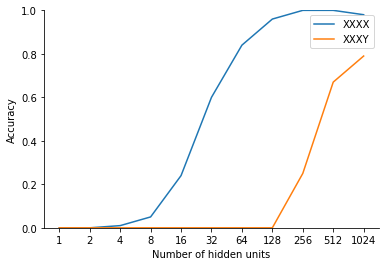

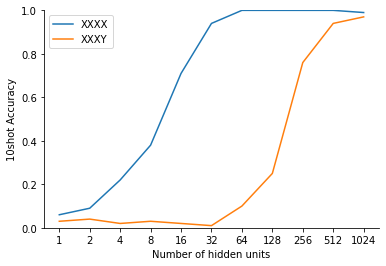

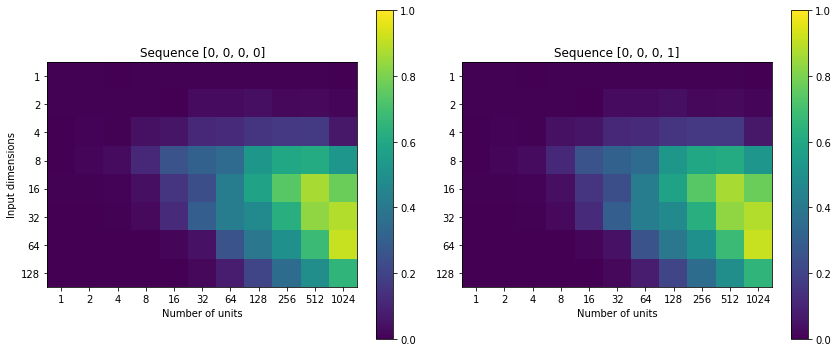

In [123]:
ax = plt.subplot(111)
plt.plot(np.arange(len(hidden)),np.mean(Accuracy[-3,:],-1))
ax.set_xticks(np.arange(len(hidden)))
ax.set_xticklabels(hidden)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('Accuracy')
ax.set_xlabel('Number of hidden units')
ax.legend(('XXXX','XXXY'))
ax.set_ylim((0,1))
plt.savefig('NIP_Gridsearch_units_Acc.pdf')
plt.savefig('NIP_Gridsearch_units_Acc.png')
plt.show()

ax = plt.subplot(111)
plt.plot(np.arange(len(hidden)),np.mean(Accuracy10[-3,:],-1))
ax.set_xticks(np.arange(len(hidden)))
ax.set_xticklabels(hidden)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('10shot Accuracy')
ax.set_xlabel('Number of hidden units')
ax.legend(('XXXX','XXXY'))
ax.set_ylim((0,1))
plt.savefig('NIP_Gridsearch_units_10shotAcc.pdf')
plt.savefig('NIP_Gridsearch_units_10shotAcc.png')
plt.show()

fig,ax = plt.subplots(1,2,figsize=(12,5))
for i in range(2):
    im = ax[i].imshow(np.mean(np.mean(Accuracy,-1),-1),vmin=0,vmax=1)
    ax[i].set_xticks(np.arange(len(hidden)))
    ax[i].set_xticklabels(hidden)
    ax[i].set_yticks(np.arange(len(in_size)))
    ax[i].set_yticklabels(in_size)
    ax[i].set_xlabel('Number of units')
    ax[i].set_title('Sequence %s'%(seq_test[i]))
    plt.colorbar(im,ax=ax[i])
ax[0].set_ylabel('Input dimensions')
plt.tight_layout()

plt.savefig('NIP_Gridsearch_unitsVSinput_Acc.pdf')
plt.savefig('NIP_Gridsearch_unitsVSinput_Acc.png')
plt.show()

Grid search dropout

In [334]:
seq = [[0,0,0,0],[0,0,0,1],[0,1,0,1],[0,0,1,1],] # sequence structures to be used
seq_test = [[0,0,0,0],[0,0,0,1],[0,1,0,1],[0,0,1,1]]
Nseq = len(seq_test)
repeats = 10 # repeats per chunk in each sequence
input_size = 10 # dimensionality of the input
dict_size = 100 # size of stimulus dictionary
n_hidden = 1024#[1,2,4,8,16,32,64,128,256,512]
n_layers = 1
deviance_prob = 0.2
dropout = [0,0.1,0.2,0.3,0.4,0.5]

# produce random stimulus pairs:
pairs = np.random.randn(dict_size,3,input_size) 
pairs_val = np.random.randn(dict_size,3,input_size)
pairs_test = np.random.randn(dict_size,3,input_size)
pairs_test_samestim = pairs.copy()[np.random.permutation(dict_size),:,:] # shuffle pairs from trained stimuli
zero_vector = np.random.randn(1,input_size) # this is used for the zero state
all_stimuli = np.concatenate((np.reshape(pairs_test,(dict_size*3,input_size)),zero_vector),0)
all_stimuli_samestim = np.concatenate((np.reshape(pairs_test_samestim,(dict_size*3,input_size)),zero_vector),0)
nstim = all_stimuli.shape[0]
    
# create training and test data
sequence = make_sequence(seq,repeats,pairs,zero_vector,deviance_prob)
test_sequence = make_sequence(seq_test,repeats,pairs_test,zero_vector,0)
val_sequence = make_sequence(seq,repeats,pairs_val,zero_vector,0)
test_sequence_samestim = make_sequence(seq_test,repeats,pairs_test_samestim,zero_vector,0)



# make torch variables
train_x = []
train_y = []
val_x = []
val_y = []
for i in range(len(seq)):
    #trainind = np.delete(np.arange(ntrials),k)
    train_x.append(torch.Tensor(sequence[i][:,:-2,:])) #!!-1 if no zero element after each chunk, otherwise -2
    train_y.append(torch.Tensor(sequence[i][:,1:-1,:])) 
    val_x.append(torch.Tensor(val_sequence[i][:,:-2,:]))
    val_y.append(torch.Tensor(val_sequence[i][:,1:-1,:]))
    
# train network
Accuracy, Accuracy10 = np.zeros((len(dropout),Nseq,dict_size)), np.zeros((len(dropout),Nseq,dict_size))
for hi,p_dropout in enumerate(dropout):
    print('%s units per layer, %s layer'%(n_hidden,n_layers))
    model = RNN(n_hidden,n_layers,input_size,p_dropout)
    Loss = train_model(train_x,train_y, val_x,val_y,model)


    # evaluation
    Acc, Acc10, Acc_samestim, Acc10_samestim, AngleAll, AngleAll_samestim, Angle, Yhat, Yhat_samestim, Ytrue, Ytrue_samestim, Hidden = [],[],[],[],[],[],[],[],[],[],[],[] 
    print('Evaluate...')
    for i in range(Nseq):
        Nback = len(seq_test[i]) + 1 # predict last N=LENGTH*3 items of sequence; + 3 for zero states
        
        # pre-allocate
        Acc.append(np.zeros((Nback,dict_size)))
        Acc10.append(np.zeros((Nback,dict_size)))
        Acc_samestim.append(np.zeros((Nback,dict_size)))
        Acc10_samestim.append(np.zeros((Nback,dict_size)))
        AngleAll.append(np.zeros((Nback,dict_size,nstim)))
        AngleAll_samestim.append(np.zeros((Nback,dict_size,nstim)))
        Angle.append(np.zeros((Nback,dict_size)))
        Yhat.append(np.zeros((dict_size,Nback,input_size))) # store prediction here
        Ytrue.append(np.zeros((dict_size,Nback,input_size))) # store ground truth
        Yhat_samestim.append(np.zeros((dict_size,Nback,input_size)) )# store prediction here
        Ytrue_samestim.append(np.zeros((dict_size,Nback,input_size)) )# store ground truth
        Hidden.append(np.zeros((dict_size,Nback,n_hidden)) )# hidden state activity
    
        
        test_x = []
        for j in range(Nback):
            if j==Nback-1:
                test_x.append(torch.Tensor(test_sequence[i]))
            else:
                test_x.append(torch.Tensor(test_sequence[i][:,:-Nback+j+1 ,:]))
    
        y,h = predict(test_x,model)
    
        for j in range(Nback):
            Yhat[i][:,j,:] = y[j]
            if j==Nback-1:
                Ytrue[i][:,j,:] = test_sequence[i][:,-Nback,:]
            else:
                Ytrue[i][:,j,:] = test_sequence[i][:,-Nback+j+1 ,:] # last item is zero state
            Hidden[i][:,j,:] = h[j][0].detach().numpy()
        
        
        # for the stimuli trained on
        test_x = []
        for j in range(Nback):
            if j==Nback-1:
                test_x.append(torch.Tensor(test_sequence_samestim[i]))
            else:
                test_x.append(torch.Tensor(test_sequence_samestim[i][:,:-Nback+j+1 ,:]))
    
        y,h = predict(test_x,model)
    
        for j in range(Nback):
            Yhat_samestim[i][:,j,:] = y[j]
            if j==Nback-1:
                Ytrue_samestim[i][:,j,:] = test_sequence_samestim[i][:,-Nback,:]
            else:
                Ytrue_samestim[i][:,j,:] = test_sequence_samestim[i][:,-Nback+j+1 ,:] # last item is zero state
    
        # compute angles and accuracy
        print('Compute accuracy sequence %s'%seq_test[i])
        for j in range(Nback): # items in sequence
            for k in range(dict_size):
                
                # test sequences
                yhat = Yhat[i][k,j,:]
                ytrue = Ytrue[i][k,j,:]
                yrep = np.repeat(ytrue[None,:],nstim,0)
                target_idx = np.argmin(np.mean(abs(yrep-all_stimuli),1))
                
                # angle with all vectors in dictionary
                ynorm = yhat/np.linalg.norm(yhat)
                dic = np.array([all_stimuli[u,:]/np.linalg.norm(all_stimuli[u,:]) for u in range(nstim)])
                for s in range(nstim):
                    AngleAll[i][j,k,s] = np.arccos(ynorm@dic[s,:]) * 180/np.pi
                # angle with correct vector
                Angle[i][j,k] = AngleAll[i][j,k,target_idx]
                Acc[i][j,k] = np.argmin(AngleAll[i][j,k,:])==target_idx
                Acc10[i][j,k] = target_idx in np.argsort(AngleAll[i][j,k,:])[:10]
                
                # stimuli trained on
                yhat = Yhat_samestim[i][k,j,:]
                ytrue = Ytrue_samestim[i][k,j,:]
                yrep = np.repeat(ytrue[None,:],nstim,0)
                target_idx = np.argmin(np.mean(abs(yrep-all_stimuli_samestim),1))
                
                ynorm = yhat/np.linalg.norm(yhat)
                dic = np.array([all_stimuli_samestim[u,:]/np.linalg.norm(all_stimuli_samestim[u,:]) for u in range(nstim)])
                for s in range(nstim):
                    AngleAll_samestim[i][j,k,s] = np.arccos(ynorm@dic[s,:]) * 180/np.pi
                # angle with correct vector
                Acc_samestim[i][j,k] = np.argmin(AngleAll_samestim[i][j,k,:])==target_idx
                Acc10_samestim[i][j,k] = target_idx in np.argsort(AngleAll_samestim[i][j,k,:])[:10]
                
    for i in range(Nseq):
        Accuracy[hi,i,:] = Acc[i][len(seq_test[i])-2,:]
        Accuracy10[hi,i,:] = Acc10[i][len(seq_test[i])-2,:]
        mean_acc = np.mean(Acc[i][len(seq_test[i])-2,:])
        mean_acc10 = np.mean(Acc10[i][len(seq_test[i])-2,:])
        print('New stimuli; Accuracy for last in sequence %s: %.3f, 10shot: %.3f'%(seq_test[i],mean_acc,mean_acc10))
        
    mean_acc = []
    for i in range(Nseq):
        
        mean_acc = np.mean(Acc_samestim[i][len(seq_test[i])-2,:])
        mean_acc10 = np.mean(Acc10_samestim[i][len(seq_test[i])-2,:])
        print('Known stimuli; Accuracy for last in sequence %s: %.3f, 10shot: %.3f'%(seq_test[i],mean_acc,mean_acc10))

512 units per layer, 1 layer


KeyboardInterrupt: 

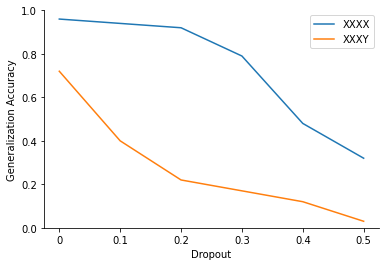

In [51]:
ax = plt.subplot(111)
plt.plot(np.arange(len(dropout)),np.mean(Accuracy10,-1))
ax.set_xticks(np.arange(len(dropout)))
ax.set_xticklabels(dropout)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('Generalization Accuracy')
ax.set_xlabel('Dropout')
ax.legend(('XXXX','XXXY'))
ax.set_ylim((0,1))
plt.savefig('NIP_Gridsearch_dropout_10shotAcc.pdf')
plt.savefig('NIP_Gridsearch_dropout_10shotAcc.png')
plt.show()

### PCA with global deviants

In [443]:
n_comp = 10

# get all hidden activations from the different sequences
n_pos = 15 # until this item position
AllHidden = np.zeros((pairs.shape[0],Nseq,n_pos,n_hidden))
Proj = []
Varexp = np.zeros((Nseq,pairs.shape[0],n_comp))
PCs = np.zeros((Nseq,pairs.shape[0],n_comp,n_hidden))
AllHidden = []
for s in range(4):
    AllH = []
    for s2 in range(1):
        AllH.append(Hidden[s+s2*1][:,:n_pos,:])
        Proj.append(np.zeros((pairs.shape[0],Hidden[s].shape[1],n_comp))) # pre-allocate
    AllHidden.append(np.concatenate(AllH,1))
for s in range(4):    
    # perform one PC for every pair
    for i in range(pairs.shape[0]):
        hidden = AllHidden[s][i,:]
        principal = PCA(n_components = n_comp)
        principal.fit(hidden)
        # project
        for s2 in range(1):
            hidden = Hidden[s+s2*1][i,:]
            x = principal.transform(hidden)
            Proj[s+1*s2][i,:,:] = x
            Varexp[s+1*s2,i,:]  = principal.explained_variance_ratio_
            PCs[s+1*s2,i,:,:] = principal.components_

In [415]:
#n_comp = 10
#Nseq = 4
## get all hidden activations from the different sequences
#n_pos = 5 # until this item position
#AllHidden = np.zeros((pairs.shape[0],Nseq,n_pos,n_hidden))
#Proj = []
#for s in range(Nseq):
#    AllHidden[:,s,:] = Hidden_samestim[s][:,:n_pos,:]
#    Proj.append(np.zeros((pairs.shape[0],Hidden_samestim[s].shape[1],n_comp))) # pre-allocate
## reshape for PCA
#AllHidden = np.reshape(AllHidden,(pairs.shape[0],Nseq*n_pos,n_hidden))
#
#Varexp = np.zeros((pairs.shape[0],n_comp))
#PCs = np.zeros((pairs.shape[0],n_comp,n_hidden))
## perform one PC for every pair
#for i in range(pairs.shape[0]):
#    hidden = AllHidden[i,:10,:]
#    principal = PCA(n_components = n_comp)
#    principal.fit(hidden)
#    # project
#    for s in range(Nseq):
#        hidden = Hidden_samestim[s][i,:]
#        x = principal.transform(hidden)
#        Proj[s][i,:,:] = x
#    Varexp[i,:]  = principal.explained_variance_ratio_
#    PCs[i,:,:] = principal.components_

In [416]:
Proj[0].shape

(100, 15, 10)

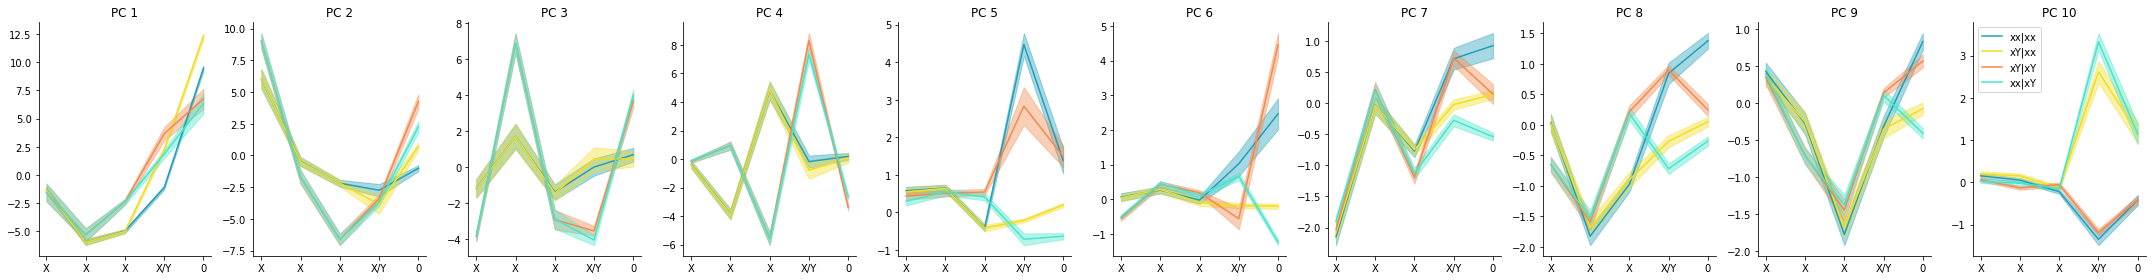

In [444]:
# visualize global standards and errors
ticks = ['X','X','X','X/Y','0']
colors = [['#229eba','#f2dd20'], # xx block
         ['#f4884d','#48e5ca']] # xY block
labels = [['xx|xx','xY|xx'],['xY|xY','xx|xY']]

plot_comp = 10
fig,ax = plt.subplots(1,plot_comp,figsize=(plot_comp*3,4))
for c in range(plot_comp):
    for s in range(2):
        for j in range(2):
            m = np.mean(Proj[s+2][:,j*5:(j+1)*5,c],0)
            sem = np.std(Proj[s+2][:,j*5:(j+1)*5,c],0)/np.sqrt(pairs.shape[0])
            ax[c].plot(np.arange(5),m,color=colors[s][j],label=labels[s][j])
            ax[c].fill_between(np.arange(5),m-sem,m+sem,color=colors[s][j],alpha=.4)
    ax[c].set_xticks(np.arange(5))
    ax[c].set_xticklabels(ticks)
    ax[c].set_title('PC %s'%(c+1))
    ax[c].spines['top'].set_visible(False)
    ax[c].spines['right'].set_visible(False)
plt.tight_layout()
plt.legend()
#plt.savefig('NIP_PCA_Trialtypes.pdf')
#plt.savefig('NIP_PCA_Trialtypes.png')
plt.show()

# Decoding

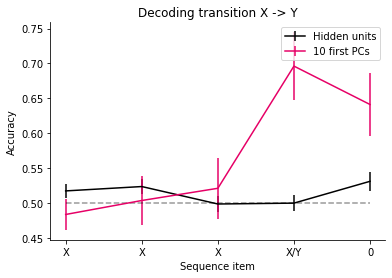

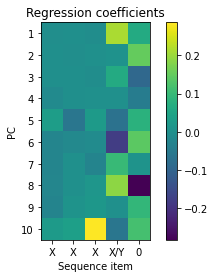

In [435]:
from sklearn.linear_model import LogisticRegression

n_stim = dict_size
n_pos = 5
# leave one out cross validation
ScorePC = np.zeros((n_stim,n_pos))
ScoreHidden = np.zeros((n_stim,n_pos))
Coef = np.zeros((n_stim,n_pos,n_comp))

for seq_pos in range(n_pos):

    
    for i in range(n_stim):
        testind = i
        ind = np.delete(np.arange(n_stim),testind) # remove test indices from training data
        # local deviant items, 
        
        #### DECODE FROM PRROJECTION
        ################# NOTE: HARD CODED; sequence 0 and 2 are XXXX, sequence 1 and 3 are xxxY,
        Xtest = Proj[1][testind,seq_pos,:]
        Xtrain = Proj[1][ind,seq_pos,:]
        Xtrain = np.concatenate((Xtrain,Proj[3][ind,seq_pos,:]),0)
        Xtrain = np.concatenate((Xtrain,Proj[0][ind,seq_pos+5,:]),0)
        Xtrain = np.concatenate((Xtrain,Proj[2][ind,seq_pos+5,:]),0)
        # add local standard sequences 
        Xtrain = np.concatenate((Xtrain,Proj[0][ind,seq_pos,:]),0)
        Xtrain = np.concatenate((Xtrain,Proj[2][ind,seq_pos,:]),0)
        Xtrain = np.concatenate((Xtrain,Proj[1][ind,seq_pos+5,:]),0)
        Xtrain = np.concatenate((Xtrain,Proj[3][ind,seq_pos+5,:]),0)
        # for test data
        Xtest = np.concatenate((Xtest[None,:],Proj[3][testind,seq_pos,:][None,:]))
        Xtest = np.concatenate((Xtest,Proj[0][testind,seq_pos+5,:][None,:]))
        Xtest = np.concatenate((Xtest,Proj[2][testind,seq_pos+5,:][None,:]))
        Xtest = np.concatenate((Xtest,Proj[0][testind,seq_pos,:][None,:]))
        Xtest = np.concatenate((Xtest,Proj[2][testind,seq_pos,:][None,:]))
        Xtest = np.concatenate((Xtest,Proj[1][testind,seq_pos+5,:][None,:]))
        Xtest = np.concatenate((Xtest,Proj[3][testind,seq_pos+5,:][None,:]))
        
        ytrain = np.concatenate((np.ones(4*len(ind)),np.zeros(4*len(ind))))
        ytest = np.concatenate((np.ones(4),np.zeros(4)))
        reg_local = LogisticRegression(solver='lbfgs',max_iter=1000).fit(Xtrain,ytrain)
        ScorePC[i,seq_pos] = reg_local.score(Xtest,ytest)
        Coef[i,seq_pos,:] = reg_local.coef_
    
        #### DECODE FROM ALL HIDDEN UNITS
        Xtest = Hidden[1][testind,seq_pos,:]
        Xtrain = Hidden[1][ind,seq_pos,:]
        Xtrain = np.concatenate((Xtrain,Hidden[3][ind,seq_pos,:]),0)
        Xtrain = np.concatenate((Xtrain,Hidden[0][ind,seq_pos+5,:]),0)
        Xtrain = np.concatenate((Xtrain,Hidden[2][ind,seq_pos+5,:]),0)
        # add local standard sequences
        Xtrain = np.concatenate((Xtrain,Hidden[0][ind,seq_pos,:]),0)
        Xtrain = np.concatenate((Xtrain,Hidden[2][ind,seq_pos,:]),0)
        Xtrain = np.concatenate((Xtrain,Hidden[1][ind,seq_pos+5,:]),0)
        Xtrain = np.concatenate((Xtrain,Hidden[3][ind,seq_pos+5,:]),0)
        # for test data
        Xtest = np.concatenate((Xtest[None,:],Hidden[3][testind,seq_pos,:][None,:]),0)
        Xtest = np.concatenate((Xtest,Hidden[0][testind,seq_pos+5,:][None,:]),0)
        Xtest = np.concatenate((Xtest,Hidden[2][testind,seq_pos+5,:][None,:]),0)
        Xtest = np.concatenate((Xtest,Hidden[0][testind,seq_pos,:][None,:]),0)
        Xtest = np.concatenate((Xtest,Hidden[2][testind,seq_pos,:][None,:]),0)
        Xtest = np.concatenate((Xtest,Hidden[1][testind,seq_pos+5,:][None,:]),0)
        Xtest = np.concatenate((Xtest,Hidden[3][testind,seq_pos+5,:][None,:]),0)
        reg_local = LogisticRegression(solver='lbfgs',max_iter=1000).fit(Xtrain,ytrain)
        ScoreHidden[i,seq_pos] = reg_local.score(Xtest,ytest)
        
ax = plt.subplot(111)
ticks = ['X','X','X','X/Y','0']
ax.errorbar(np.arange(n_pos),np.mean(ScoreHidden,0),yerr=np.std(ScoreHidden,0)/np.sqrt(n_stim),color='k',label='Hidden units')
ax.errorbar(np.arange(n_pos),np.mean(ScorePC,0),yerr=np.std(ScorePC,0)/np.sqrt(np.sqrt(n_stim)),color=[.9,0,.4],label='%s first PCs'%n_comp)
ax.plot(np.arange(n_pos),np.ones(n_pos)*.5,'k--',alpha=.4)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('Accuracy')
ax.set_title('Decoding transition X -> Y')
ax.legend()
ax.set_xticks(np.arange(n_pos))
ax.set_xticklabels(ticks)
ax.set_xlabel('Sequence item')
#plt.savefig('NIP_Decoding_Y.png')
#plt.savefig('NIP_Decoding_Y.pdf')
plt.show()# 


ax = plt.subplot(111)
plt.imshow(np.mean(Coef,0).T)
plt.colorbar()
ax.set_xticks(np.arange(n_pos))
ax.set_xticklabels(ticks)
ax.set_yticks(np.arange(n_comp))
ax.set_yticklabels(np.arange(n_comp)+1)
ax.set_ylabel('PC')
ax.set_xlabel('Sequence item')
ax.set_title('Regression coefficients')
#plt.savefig('NIP_Decoding_Y_coefficients.png')
#plt.savefig('NIP_Decoding_Y_coefficients.pdf')
plt.show()


### Decode global

In [ ]:
from sklearn.linear_model import LogisticRegression

n_stim = dict_size
# leave one out cross validation
ScorePC = np.zeros((n_stim,n_pos))
ScoreHidden = np.zeros((n_stim,n_pos))
Coef = np.zeros((n_stim,n_pos,n_comp))
n_pos = 5
for seq_pos in range(n_pos):

    
    for i in range(n_stim):
        testind = i
        ind = np.delete(np.arange(n_stim),testind) # remove test indices from training data
        # local deviant items, 
        
        #### DECODE FROM PRROJECTION
        ################# NOTE: HARD CODED; sequence 0 and 2 are XXXX, sequence 1 and 3 are xxxY,
        Xtest = Proj[0][testind,seq_pos,:]
        Xtrain = Proj[0][ind,seq_pos,:]
        Xtrain = np.concatenate((Xtrain,Proj[1][ind,seq_pos,:]),0)
        Xtrain = np.concatenate((Xtrain,Proj[2][ind,seq_pos,:]),0)
        Xtrain = np.concatenate((Xtrain,Proj[3][ind,seq_pos,:]),0)
        Xtrain = np.concatenate((Xtrain,Proj[0][ind,seq_pos+5,:]),0)
        Xtrain = np.concatenate((Xtrain,Proj[1][ind,seq_pos+5,:]),0)
        Xtrain = np.concatenate((Xtrain,Proj[2][ind,seq_pos+5,:]),0)
        Xtrain = np.concatenate((Xtrain,Proj[3][ind,seq_pos+5,:]),0)
        # for test data
        Xtest = np.concatenate((Xtest[None,:],Proj[1][testind,seq_pos,:][None,:]))
        Xtest = np.concatenate((Xtest,Proj[2][testind,seq_pos,:][None,:]))
        Xtest = np.concatenate((Xtest,Proj[3][testind,seq_pos,:][None,:]))
        Xtest = np.concatenate((Xtest,Proj[0][testind,seq_pos+5,:][None,:]))
        Xtest = np.concatenate((Xtest,Proj[1][testind,seq_pos+5,:][None,:]))
        Xtest = np.concatenate((Xtest,Proj[2][testind,seq_pos+5,:][None,:]))
        Xtest = np.concatenate((Xtest,Proj[3][testind,seq_pos+5,:][None,:]))
        
        ytrain = np.concatenate((np.zeros(4*len(ind)),np.ones(4*len(ind))))
        ytest = np.concatenate((np.zeros(4),np.ones(4)))
        reg_local = LogisticRegression(solver='lbfgs',max_iter=1000).fit(Xtrain,ytrain)
        ScorePC[i,seq_pos] = reg_local.score(Xtest,ytest)
        Coef[i,seq_pos,:] = reg_local.coef_
    
        ### DECODE FROM ALL HIDDEN UNITS
        Xtest = Hidden[0][testind,seq_pos,:]
        Xtrain = Hidden[0][ind,seq_pos,:]
        Xtrain = np.concatenate((Xtrain,Hidden[1][ind,seq_pos,:]),0)
        Xtrain = np.concatenate((Xtrain,Hidden[2][ind,seq_pos,:]),0)
        Xtrain = np.concatenate((Xtrain,Hidden[3][ind,seq_pos,:]),0)
        Xtrain = np.concatenate((Xtrain,Hidden[0][ind,seq_pos+5,:]),0)
        Xtrain = np.concatenate((Xtrain,Hidden[1][ind,seq_pos+5,:]),0)
        Xtrain = np.concatenate((Xtrain,Hidden[2][ind,seq_pos+5,:]),0)
        Xtrain = np.concatenate((Xtrain,Hidden[3][ind,seq_pos+5,:]),0)
        # for test data
        Xtest = np.concatenate((Xtest[None,:],Hidden[1][testind,seq_pos,:][None,:]),0)
        Xtest = np.concatenate((Xtest,Hidden[2][testind,seq_pos,:][None,:]),0)
        Xtest = np.concatenate((Xtest,Hidden[3][testind,seq_pos,:][None,:]),0)
        Xtest = np.concatenate((Xtest,Hidden[0][testind,seq_pos+5,:][None,:]),0)
        Xtest = np.concatenate((Xtest,Hidden[1][testind,seq_pos+5,:][None,:]),0)
        Xtest = np.concatenate((Xtest,Hidden[2][testind,seq_pos+5,:][None,:]),0)
        Xtest = np.concatenate((Xtest,Hidden[3][testind,seq_pos+5,:][None,:]),0)
        reg_local = LogisticRegression(solver='lbfgs',max_iter=1000).fit(Xtrain,ytrain)
        ScoreHidden[i,seq_pos] = reg_local.score(Xtest,ytest)
        
ax = plt.subplot(111)
ticks = ['X','X','X','X/Y','0']
ax.errorbar(np.arange(n_pos),np.mean(ScoreHidden,0),yerr=np.std(ScoreHidden,0)/np.sqrt(n_stim),color='k',label='Hidden units')
ax.errorbar(np.arange(n_pos),np.mean(ScorePC,0),yerr=np.std(ScorePC,0)/np.sqrt(np.sqrt(n_stim)),color=[.9,0,.4],label='%s first PCs'%n_comp)
ax.plot(np.arange(n_pos),np.ones(n_pos)*.5,'k--',alpha=.4)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('Accuracy')
ax.set_title('Decoding transition X -> Y')
ax.legend()
ax.set_xticks(np.arange(n_pos))
ax.set_xticklabels(ticks)
ax.set_xlabel('Sequence item')
#plt.savefig('NIP_Decoding_Y.png')
#plt.savefig('NIP_Decoding_Y.pdf')
plt.show()# 


ax = plt.subplot(111)
plt.imshow(np.mean(Coef,0).T)
plt.colorbar()
ax.set_xticks(np.arange(n_pos))
ax.set_xticklabels(ticks)
ax.set_yticks(np.arange(n_comp))
ax.set_yticklabels(np.arange(n_comp)+1)
ax.set_ylabel('PC')
ax.set_xlabel('Sequence item')
ax.set_title('Regression coefficients')
#plt.savefig('NIP_Decoding_Y_coefficients.png')
#plt.savefig('NIP_Decoding_Y_coefficients.pdf')
plt.show()


# Tuning curves

In [446]:
def getTC(x,hidden,seq):
    '''
    x: list of squences of stimuli used to compute hidden
    hidden: hidden activity of network for each sequence
    seq: sequence chunks used (needed for length)
    '''
    nstim, ndim = x[0].shape[0],x[0].shape[2]
    nhidden = hidden[0].shape[-1]
    all_x = []
    all_h = []
    for i in range(len(x)):
        Nback = 3*len(seq[i]) + 3 # only works for this sequence length
        xi = x[i][:,-Nback:,:]
        xi = np.reshape(xi,(nstim*Nback,ndim))
        hi = np.reshape(hidden[i],(nstim*Nback,nhidden))
        all_x.append(xi)
        all_h.append(hi)
    all_x = np.concatenate(all_x)
    all_h = np.concatenate(all_h)
    print(all_x.shape)
    
    return all_x,all_h

In [447]:
x,h = getTC(test_sequence,Hidden,seq_test)

(6000, 64)


In [451]:
stepsize = 1
bins = np.arange(-3,3,stepsize)
TC = np.zeros((x.shape[1],h.shape[1],len(bins)))
for neuron in range(h.shape[1]):
    for stimulus in range(x.shape[1]):
        ind = np.argsort(x[:,stimulus])
        h_sort = h[ind,neuron]
        x_sort = x[ind,stimulus]
        
        for i in range(len(bins)):
            if i==len(bins)-1:
                TC[stimulus,neuron,i] = np.nanmean(h_sort[x_sort>=bins[i]])
            else:
                TC[stimulus,neuron,i] = np.nanmean(h_sort[(x_sort>=bins[i]) & (x_sort<bins[i+1])])


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == '':
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  


In [448]:
from scipy.stats import rankdata, pearsonr
x_rank = rankdata(x,axis=0)
h_rank = rankdata(h,axis=0)
r = np.zeros((x.shape[1],h.shape[1]))
p = np.zeros((x.shape[1],h.shape[1]))
for neuron in range(h.shape[1]):
    for stimulus in range(x.shape[1]):
        r[stimulus,neuron],p[stimulus,neuron] = pearsonr(x_rank[:,stimulus],h_rank[:,neuron])

In [449]:
r_av = np.mean(abs(r),0)


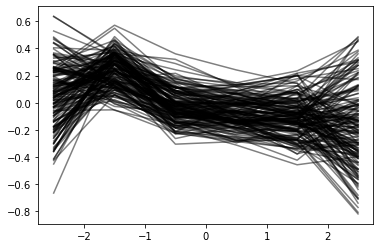

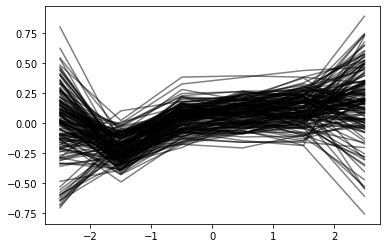

In [452]:
ind1 = r[0,:]<-0.15
plt.plot(bins+stepsize/2,TC[0,ind1==True,:].T,'k',alpha=.5)
plt.show()
ind1 = r[0,:]>0.15
plt.plot(bins+stepsize/2,TC[0,ind1==True,:].T,'k',alpha=.5)
plt.show()

(array([129., 334., 195., 130.,  96.,  56.,  36.,  29.,  12.,   7.]),
 array([0.04315604, 0.05882813, 0.07450023, 0.09017232, 0.10584442,
        0.12151651, 0.13718861, 0.1528607 , 0.1685328 , 0.18420489,
        0.19987699]),
 <BarContainer object of 10 artists>)

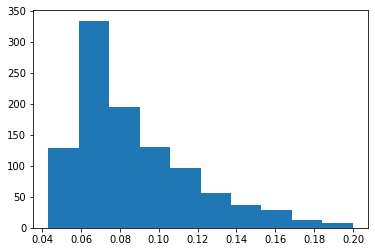

In [453]:
plt.hist(r_av)

(0.6927333246555627, 3.056543985198236e-147)
(0.5547711983596499, 1.0463132389322752e-83)
(0.6713481220642901, 4.064401496168731e-135)
(0.528226315349421, 1.1776808818107547e-74)


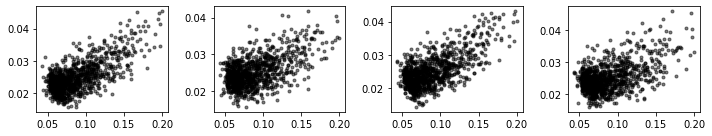

In [477]:
which_comp = 0
fig,ax = plt.subplots(1,4,figsize=(10,2))
for i in range(Nseq):
    ax[i].plot(np.mean(abs(r),0),np.mean(abs(PCs[i,:,which_comp,:]),0),'k.',alpha=.5)
    print(pearsonr(r_av,np.mean(abs(PCs[i,:,which_comp,:]),0)))
plt.tight_layout()

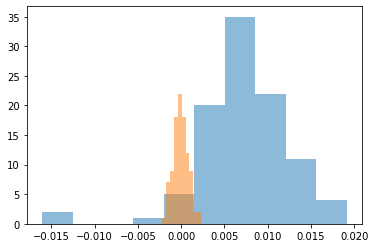

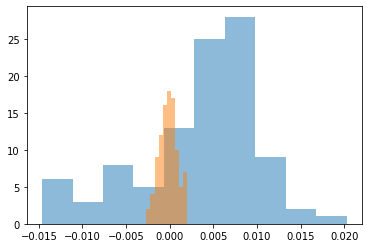

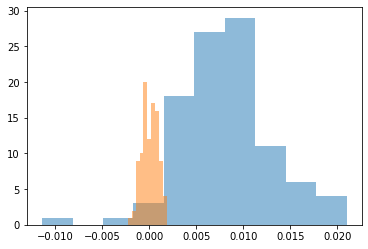

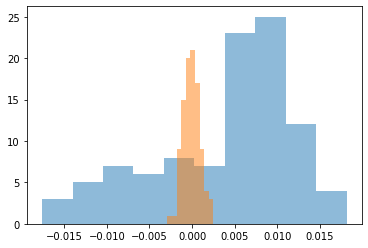

In [479]:
for i in range(Nseq):
    plt.hist(np.mean(PCs[i,:,0,np.mean(abs(r),0)>0.15],0),10,alpha=.5)
    plt.hist(np.mean(PCs[i,:,0,np.mean(abs(r),0)<0.15],0),10,alpha=.5)
    plt.show()

The stronger the relationship between a stimulus dimension with the response of a unit (in other words the stronger the tuning), the larger the contribution of that unit to the first PC space. 